<a href="https://colab.research.google.com/github/hiebschi/MoSE_scripts/blob/main/loop_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a Segmentation Model

## 1. Preparations
### 1.1 Install required packages

In [1]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [2]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


### 1.2 Install segmentation model

In [3]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=53251bca296b25feb3911fcf2c7cb7c1a7f121d3de068b78612477a2dc308a32
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=6f7bbe66c63d082411e89bd3a97e6170014979b7b1188fd8a667353049006d11
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [4]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Connect my drive to colab

In [6]:
# manual upload (for small files)
# from google.colab import files
# uploaded = files.upload()

In [7]:
# manual upload through Files Tab (right Tab)
!ls /content

sample_data


In [8]:
# ACCESS TO GOOGLE DRIVE
################################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.5 Set data directories

In [9]:
################################################################################
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
################################################################################
# npy preprocessed patches
preprocessed_patches_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/preprocessed_patches'
# JSON class codes
codes_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/classes'
# Shapefile class labels
labels_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/shapefiles'
# npy Masks
masks_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/masks'

### 1.6 Check the data

1. Class labels and codes

In [10]:
# Load class labels
################################################################################
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [11]:
# Load class codes
################################################################################
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [12]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

2. Preprocessed patches

In [13]:
################################################################################
# Load preprocessed patches
################################################################################

# list of all .npz-files (.npz-compression)
################################################################################
patches_npz_list = [f for f in os.listdir(preprocessed_patches_dir) if f.endswith('.npz')]
patches_npz_list.sort()
patches_npz_list[0:3]

['A01_patch_0.npy.npz', 'A01_patch_1.npy.npz', 'A01_patch_10.npy.npz']

In [14]:
################################################################################
# SLOW VERSION TO LOAD ALL PATCHES (arrays)
################################################################################

# # empty list for saving loaded arrays (patches)
# patches = []

# for idx, patch_npz_name in enumerate(patches_npz_list): # iterates over all npz-patches in the list
#   patch_npz_path = os.path.join(preprocessed_patches_dir, patch_npz_name) # path to npz-patch

#   with np.load(patch_npz_path) as data: # load npz-patch

#     array_keys = list(data.keys()) # access to array in the npz-patch
#     # print(f"Array Keys: {array_keys}")

#     if len(array_keys) > 1: # if more than 1 array in the npz-patch
#       print(f"WARNING MESSAGE: .npz-file '{patch_npz_name}' contains {len(array_keys)} arrays: {array_keys}") # Warning message

#     patch_name = patch_npz_name.replace(".npz", "") # change to .npy-name
#     array_data = data[array_keys[0]] # extract array data
#     patches.append((patch_name, array_data)) # save as tuple of patch name and corresponding data in the patches list

#     if idx % 100 == 0: # show progress
#       print(f"{idx}/{len(patches_npz_list)} files loaded.")

# print(f"In total {len(patches)} patches successfully loaded.")

In [15]:
################################################################################
# FAST VERSION
################################################################################

# from concurrent.futures import ThreadPoolExecutor, as_completed # import ThreadPoolExecutor for parallelization (parallel loading of patches in each batch)

# # Final list to save loaded patches (name, data)
# patches = []

# # Function to load a single .npz file and extract the first array
# def load_npz_file(file_name, directory):
#     """ Load an .npz file, extract the first array, and return (name, array). """
#     file_path = os.path.join(directory, file_name) # path to .npz-file

#     try:
#         with np.load(file_path) as data:  # Load the .npz file

#             array_keys = list(data.keys())  # Get all keys (array names)

#             if len(array_keys) > 1:  # Print a warning if multiple arrays are present
#                 print(f".npz-file '{file_name}' contains {len(array_keys)} arrays: {array_keys}")

#             patch_name = file_name.replace(".npz", "")  # Remove '.npz' to get the base name
#             array_data = data[array_keys[0]]  # Extract the first array

#             return (patch_name, array_data)  # Return a tuple (name, array)

#     except Exception as e:  # Handle any errors during file loading
#         print(f"Error loading {file_name}: {e}")
#         return None

# # Batch size to load files in chunks
# batch_size = 100

# # Use ThreadPoolExecutor for parallel file loading
# for i in range(0, len(patches_npz_list), batch_size):
#     batch_files = patches_npz_list[i:i + batch_size]  # Get a batch of files
#     print(f"Processing batch {i // batch_size + 1}/{(len(patches_npz_list) // batch_size) + 1}...")

#     # List to temporarily store loaded patches from the current batch
#     batch_patches = []

#     # Parallel loading within the batch
#     with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers as needed
#         futures = [executor.submit(load_npz_file, file_name, preprocessed_patches_dir) for file_name in batch_files]

#         # Collect results as they are completed
#         for future in as_completed(futures):
#             result = future.result()
#             if result:  # Only append successful results
#                 batch_patches.append(result)

#     patches.extend(batch_patches)  # Add the loaded batch to the final list
#     print(f"Loaded {len(batch_patches)} patches in this batch.")

# # Summary
# print(f"\nIn total {len(patches)} patches successfully loaded.")

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: -0.5852690845132008
Minimum value: -2.1179039301310043
Maximum value: 2.273986928104575
Minimum and maximum after normalization: 0.0 & 1.0


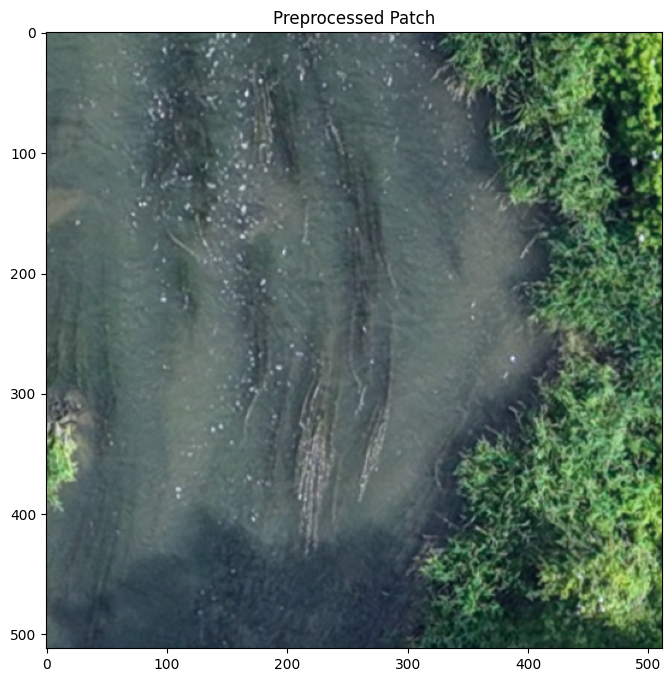

In [16]:
# Test preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 16 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy.npz"

# load npz-file
test_patch_npz = np.load(test_patch_path)
# print(test_pre_patch_npz)

# undo the .npz-compression by extracting the first array
for array in test_patch_npz.files:
  # print(array)
  # extract image data (first array)
  test_patch = test_patch_npz[array]

  # Show properties of the patch
  print("Shape of the patches:", test_patch.shape)
  print("Datatype:", test_patch.dtype)
  print("Type:", type(test_patch))
  print("Mean:", np.mean(test_patch))
  print("Minimum value:", np.min(test_patch))
  print("Maximum value:", np.max(test_patch))

# Normalization of the image data
test_patch_normalized = test_patch - np.min(test_patch ) # set minimum to 0
test_patch_normalized = test_patch_normalized / np.max(test_patch_normalized)  # maximize to 1
print("Minimum and maximum after normalization:", np.min(test_patch_normalized), "&", np.max(test_patch_normalized))

# Plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_patch_normalized.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed Patch")
plt.show()

3. Masks

In [17]:
################################################################################
# Load masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_list.sort() # sort list alphabetically
# masks_list

Shape of the mask: (9, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


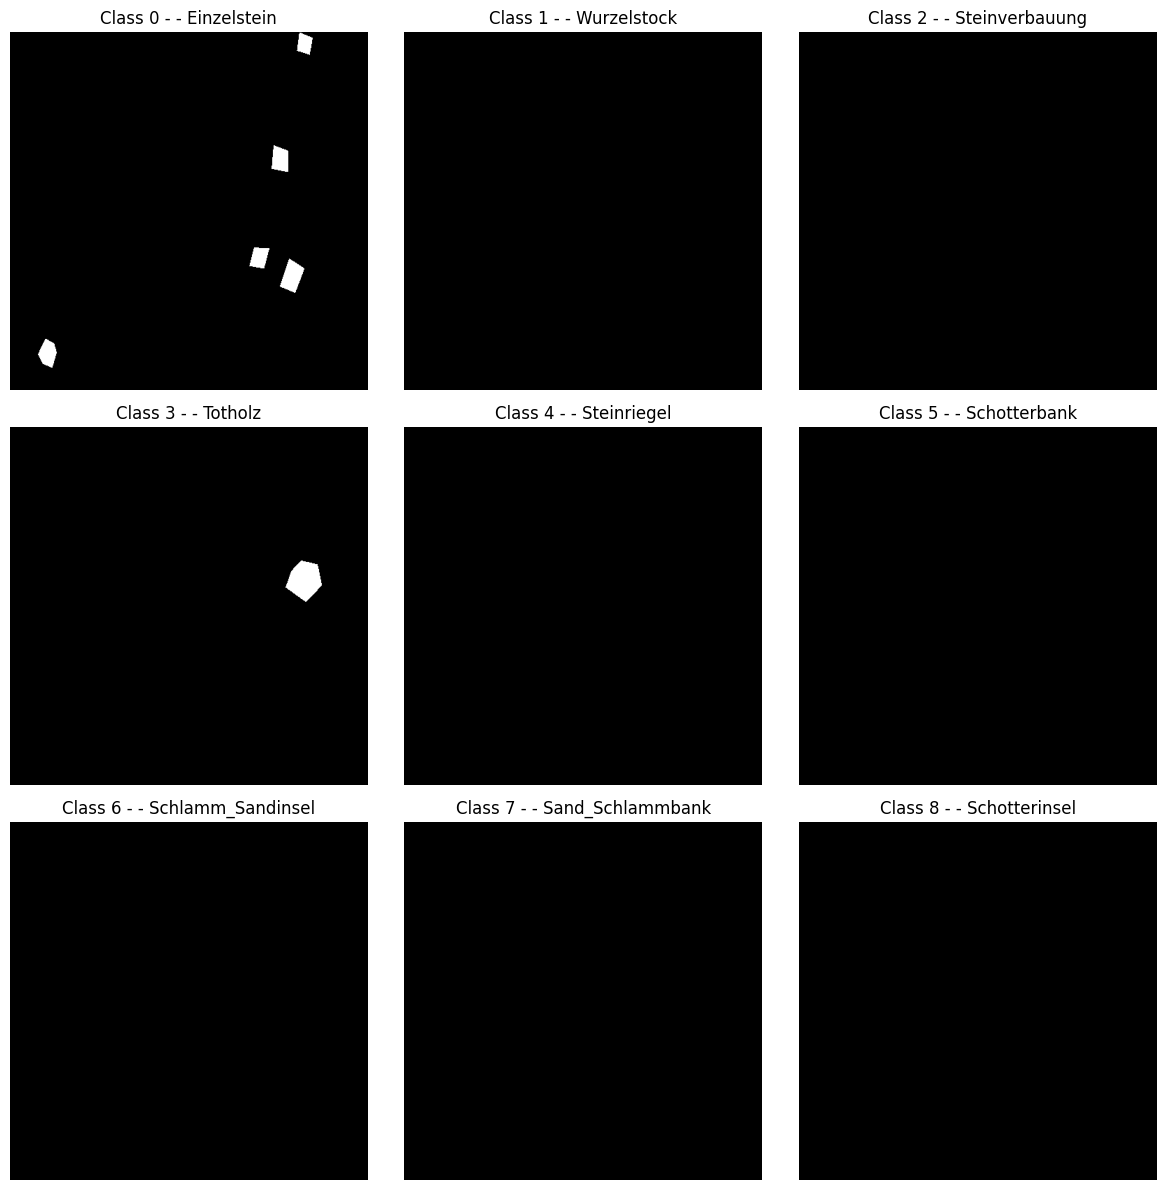

In [18]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 96 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask)) # binary mask

# Plot the mask
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the 9 classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2. Splitting data into training and test datasets

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# pre_patches_list
# masks_list

In [21]:
# helper-function in order to extract section and patch_id
def extract_section_and_id(file_name):
    parts = file_name.split("_") # split condition: _
    section = parts[0]  # extract section from file_name, e.g. "A01"
    patch_id = parts[2].replace(".npy.npz", "").replace("_mask", "") #  extract patch_id, e.g. 481
    return section, patch_id

In [22]:
# print section and patch_id from masks and patches
print(extract_section_and_id(masks_list[1]))
print(extract_section_and_id(patches_npz_list[175]))

('A01', '103')
('A01', '256')


In [23]:
# group patches by section
section_patches = {} # empty dictionary
for patch in patches_npz_list: # iterate over all preprocessed patches
    section, patch_id = extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

In [24]:
print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08'])


In [25]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################
### HYPERPARAMETER ### -------------------->> ADJUSTABLE
TRAIN_SECTIONS = ["A01", "A02", "A03", "A04", "A05", "A08"]  # Train sections
TEST_SECTIONS = ["A06", "A07"]  # Validation/Test sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in TRAIN_SECTIONS: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in TEST_SECTIONS:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")

Training Patches: 8130
Test Patches: 3043


In [26]:
train_data[8]

'A01_patch_105.npy.npz'

In [27]:
# helper-function to determine whether or not a patch has a corresponding mask
def has_mask(patch_name, masks_dir):

    """ Check if a patch has a corresponding mask in the masks directory.

    Args:
        patch_name (str): Name of the patch (e.g., 'A01_patch_481.npy.npz').
        masks_dir (str): Directory where masks are stored.
    """

    mask_path = os.path.join(masks_dir, patch_name.replace(".npy.npz", "_mask.npy")) # load corresponding mask path
    return os.path.exists(mask_path) # check if path exists

# test helper-function
has_mask(train_data[8], masks_dir)

True

In [28]:
# Separate training and test patches according to whether they have a corresponding mask into label patches and background patches
train_with_masks = [f for f in train_data if has_mask(f, masks_dir)]
# print(train_with_masks)
train_background = [f for f in train_data if not has_mask(f, masks_dir)]
test_with_masks = [f for f in test_data if has_mask(f, masks_dir)]
test_background = [f for f in test_data if not has_mask(f, masks_dir)]

print(f"Training with masks: {len(train_with_masks)}")
print(f"Training background: {len(train_background)}")
print(f"Test with masks: {len(test_with_masks)}")
print(f"Test background: {len(test_background)}")

Training with masks: 2323
Training background: 5807
Test with masks: 724
Test background: 2319


## 3. Dataset and DataLoader

### 3.1 Patch loading functions

In [29]:
# helper-function to load a single .npz file and extract the first array
# function for undoing the .npz-compression! unzip!
def load_npz_patch(patch_npz_name, patches_npz_dir):

    """ Load patch .npz file and undo the .npz compression by extracting the first array and returning it as npy-array.

    Args:
        patch_npz_name (str): Name of the patch .npz file.
        patches_npz_dir (str): Directory where patch .npz files are stored.
    """

    patch_npz_path = os.path.join(patches_npz_dir, patch_npz_name) # path to .npz-file

    try:
        with np.load(patch_npz_path, mmap_mode='r') as data:  # Load the patch .npz-file
        # use memory mapping (mmap_mode='r') for more efficient loading
        # (without loading the total content into RAM)

            array_keys = list(data.keys())  # Get all keys (array names)

            if len(array_keys) > 1:  # Print a warning if multiple arrays are present
                print(f".npz-file '{patch_npz_name}' contains {len(array_keys)} arrays: {array_keys}")

            patch_name = patch_npz_name.replace(".npz", "")  # Remove '.npz' to get the base name

            patch_image = data[array_keys[0]]  # Extract the first array


            return (patch_name, patch_image)

    except Exception as e:  # Handle any errors during file loading
        print(f"Error loading {patch_npz_name}: {e}")
        return None

In [30]:
from concurrent.futures import ThreadPoolExecutor

# Parallel .npz load function
def parallel_load_npz(patches_npz_list, patches_npz_dir):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda fname: load_npz_patch(fname, patches_npz_dir), patches_npz_list))
    return [res for res in results if res is not None]  # Filter out failed loads

### 3.2 Dataset

In [71]:
from torch.utils.data import Dataset

class PatchDataset(Dataset):
    def __init__(self, patches_npz_list, patches_npz_dir, masks_dir=None, transform=None, preload = False): # initializes the dataset by saving list of .npz-patches, the directory of the .npz-patches and the masks and optional transformations and preloads

        """
        Custom Dataset for loading .npz patches and optional masks.
        Args:
            patches_npz_list (list): List of the patch .npz-files.
            patches_npz_dir (str): Directory containing patch .npz-files.
            masks_dir (str): Directory containing mask.npy files (optional).
            transform (callable, optional): Transformation to be applied to the data.
            preload (bool): Whether to preload all patches into memory.
        """

        self.patches_npz_list = patches_npz_list
        self.patches_npz_dir = patches_npz_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.preload = preload

        if preload:
            # Parallel loading of patches using ThreadPoolExecutor
            print("Preloading patches...")
            self.preloaded_patches = parallel_load_npz(patches_npz_list, patches_npz_dir)
        else:
            self.preloaded_patches = None

    def __len__(self):

        """
        Returns the number of .npz-patches in the dataset.
        """

        return len(self.patches_npz_list) # returns the number of .npz-patches for the DataLoader

    def __getitem__(self, idx): # loads patch and corresponding mask

        """
        Returns the patch and its corresponding mask.

        Args:
            idx (int): Index of the patch in the dataset.
        Returns:
            tuple: A tuple containing the patch and its mask.
        """

        if self.preload and self.preloaded_patches is not None:
            # Use preloaded patch
            patch_name, patch = self.preloaded_patches[idx] # save patch name and patch image data
        else:
            # Load .npz-patch dynamically with patch loading function (see 4.1)
            patch_name, patch = load_npz_patch(self.patches_npz_list[idx], self.patches_npz_dir) # save patch name and patch image data

        # Convert patch into Tensor and change dtype to float32
        patch = torch.tensor(patch, dtype=torch.float32)

        # Load the mask if available
        if self.masks_dir:
            mask_path = os.path.join(self.masks_dir, patch_name.replace(".npy", "_mask.npy"))
            if os.path.exists(mask_path):
                mask = np.load(mask_path) # load mask
                mask = torch.tensor(mask, dtype=torch.float32) # convert mask into Tensor and change datatype to float32
            else:
                mask = torch.zeros((9, patch.shape[1], patch.shape[2]), dtype=torch.float32)  # Create default background mask = all pixels in all channels (= classes) are zeros
        else:
            mask = torch.zeros((9, patch.shape[1], patch.shape[2]), dtype=torch.float32)  # Default background mask

        # Apply any transformations if needed
        if self.transform:
            patch, mask = self.transform(patch, mask)

        # Ensure mask has the correct number of channels
        if mask.shape[0] != 9:  # If mask doesn't have 9 channels
          print("WARNING: NOT 9 CHANNELS!")
          mask = mask.unsqueeze(0)  # Add a channel dimension to the beginning to make it (1, H, W)
          mask = mask.repeat(9, 1, 1) # Repeat this along the channel dimension 9 times to get the desired shape (9, H, W)

        return patch_name, patch, mask

In [72]:
# Apply Datasets
# Train datasets
train_dataset = PatchDataset(train_with_masks, preprocessed_patches_dir, masks_dir, preload = False) # with masks
# ATTENTION!: "preload = True" leads to crash because of an overuse of cpu-RAM!

# check properties of the mask dataset:
print("Train dataset with class labels:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print(type(train_dataset[0][0]))
print(train_dataset[0][0])
print(train_dataset[0][1].shape)
print(train_dataset[0][2].shape, "\n")

train_background_dataset = PatchDataset(train_background, preprocessed_patches_dir) # background

# check properties of the background dataset:
print("Train dataset without any class labels = background:\n")
print("Type of dataset:", type(train_background_dataset))
print("Number of patches:", len(train_background_dataset))
print(type(train_background_dataset[0][0]))
print(train_background_dataset[0][0])
print(train_background_dataset[0][1].shape)
print(train_background_dataset[0][2].shape)

# Test datasets
test_dataset = PatchDataset(test_with_masks, preprocessed_patches_dir, masks_dir) # with masks
test_background_dataset = PatchDataset(test_background, preprocessed_patches_dir) # background

Train dataset with class labels:

Type of dataset: <class '__main__.PatchDataset'>
Number of patches: 2323
<class 'str'>
A01_patch_0.npy
torch.Size([3, 512, 512])
torch.Size([9, 512, 512]) 

Train dataset without any class labels = background:

Type of dataset: <class '__main__.PatchDataset'>
Number of patches: 5807
<class 'str'>
A01_patch_10.npy
torch.Size([3, 512, 512])
torch.Size([9, 512, 512])


### 3.3 DataLoader

Right now our data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into a model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [73]:
# Set batch size
# HYPERPARAMETER
##############################
BATCH_SIZE = 4 # -------------------->> ADJUSTABLE
##############################

In [74]:
from torch.utils.data import DataLoader

# Combine Masked and Background datasets into one DataLoader

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)
train_background_loader = DataLoader(train_background_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_background_loader = DataLoader(test_background_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Number of Training Background Batches: {len(train_background_loader)}")
print(f"Number of Test Batches: {len(test_loader)}")
print(f"Number of Test Background Batches: {len(test_background_loader)}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7a2c3359ecb0>
Number of Training Batches: 581 = up to 2324 patches
Number of Training Background Batches: 1452
Number of Test Batches: 181
Number of Test Background Batches: 580


### 3.4 Data exploration

In [75]:
# Explore one batch of data in train_loader
for batch_idx, (names, images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
    print(f"Names - fourth (last) patch name of the batch: {names[3]}", "\n------------")
    print(f"Image type: {type(images)}")
    print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
    print(f"Image excerpt of the tenth patch: {images[3,:,:4,:4]}")
    print(f"Images dtype: {images.dtype}", "\n------------")
    print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
    print(f"Mask excerpt of the mask of the tenth patch: {masks[3,:,:2,:2]}")
    print(f"Masks dtype: {masks.dtype}")
    break

Batch 1: 
------------
------------
Names - fourth (last) patch name of the batch: A05_patch_953.npy 
------------
Image type: <class 'torch.Tensor'>
Images shape: torch.Size([4, 3, 512, 512])
Image excerpt of the tenth patch: tensor([[[0.2111, 0.1939, 0.2967, 0.4679],
         [0.1426, 0.1254, 0.2453, 0.3994],
         [0.1083, 0.0569, 0.2282, 0.3823],
         [0.1768, 0.2111, 0.3481, 0.4679]],

        [[0.3803, 0.3627, 0.4328, 0.6078],
         [0.3277, 0.2927, 0.3978, 0.5553],
         [0.2752, 0.2227, 0.3803, 0.5378],
         [0.3277, 0.3627, 0.5203, 0.6429]],

        [[0.4962, 0.5136, 0.5834, 0.7054],
         [0.4614, 0.4439, 0.5659, 0.6879],
         [0.4091, 0.3568, 0.5485, 0.6879],
         [0.4614, 0.4614, 0.6356, 0.7576]]])
Images dtype: torch.float32 
------------
Masks shape: torch.Size([4, 9, 512, 512])
Mask excerpt of the mask of the tenth patch: tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

  

In [76]:
# Check if there are any labels of class "Totholz" in one batch in the train_loader
for batch_idx, batch in enumerate(train_loader):
    patch_names, images, masks = batch

    # extract mask for class 4 "Totholz"
    class_4_mask = masks[:, 3, :, :]
    print(class_4_mask.shape, "\n") # [batch_size (number of patches), height, width]

    # test if there are any labels for class 4 "Totholz"
    has_class_4_labels = (class_4_mask > 0).any().item()

    # print batch and if there are any labels for class 4
    print(f"Batch {batch_idx + 1}:")
    print(f"Contains class 4 labels: {has_class_4_labels}")

    # if there are any labels for class 4 in one patch, print the names of the patch
    if has_class_4_labels:
        for i, patch_name in enumerate(patch_names):
            if (class_4_mask[i] > 0).any().item():
                print(f"Patch with class 4 labels: {patch_name}")
    break


torch.Size([4, 512, 512]) 

Batch 1:
Contains class 4 labels: True
Patch with class 4 labels: A05_patch_984.npy
Patch with class 4 labels: A02_patch_1143.npy
Patch with class 4 labels: A03_patch_912.npy
Patch with class 4 labels: A01_patch_743.npy


## 4. Segmentation model

In [59]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
).to(device)

In [40]:
# show model costruction
# model.to(device)

In [41]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [42]:
next(model.parameters()).device

device(type='cuda', index=0)

In [43]:
dummy_x = torch.rand([1, 3, 512, 512])
model(dummy_x.to(device)).shape

torch.Size([1, 9, 512, 512])

In [44]:
# Make logits with the untrained model
with torch.inference_mode():
  untrained_logits = model(dummy_x.to(device))
print(f"Length: {len(untrained_logits)}, Shape: {untrained_logits.shape}")
# print(untrained_logits[0])

Length: 1, Shape: torch.Size([1, 9, 512, 512])


In [45]:
# Use sigmoid activation function on our model logits to turn them into prediction probabilities
untrained_pred_probs = torch.sigmoid(untrained_logits)
# untrained_pred_probs
# Find the predicted labels (round the prediction probabilities)
untrained_preds = torch.round(untrained_pred_probs)
untrained_preds.shape
# untrained_preds

torch.Size([1, 9, 512, 512])

### 4.1 Setup loss, optimizer and evaluation metrics

In [100]:
# Setup loss function and optimizer
loss_fn =  torch.nn.CrossEntropyLoss()
# loss_fn = smp.losses.DiceLoss(mode="multiclass")
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [79]:
# Calculate accuracy (classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to truth labels..

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 3.2 Creating a function to time our experiments
Timing function to measure the time it takes our model to train!

In [48]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [49]:
# test the function
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, device)

Train time on cuda: 0.000 seconds


4.12140000207728e-05

### 3.3 Creating a training loop and training a model on batches of data

Our data batches are contained within our `DataLoader`s, `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

And since we're computing on batches of data, our loss and evaluation metrics will be calculated **per batch** rather than across the whole dataset.

This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all.

In [80]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
# train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (names, images, masks) in enumerate(train_loader): # gibt sowohl den aktuellen Schleifenindex (batch) als auch den aktuellen Batch an Daten zurück

        # Put data to target device
        images, masks = images.to(device), masks.to(device)

        model.train()
        # 1. Forward pass
        y_pred = model(images)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, masks)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        # The optimizer will update a model's parameters once per batch rather than once per epoch!!!

        # Print out how many samples have been seen
        if batch % 100 == 0:
            print(f"Looked at {batch * len(images)}/{len(train_loader.dataset)} samples")
        # end of the train batch loop

    # Divide total train loss by length of train dataloader (average loss per batch per epoch) # we are now in the epoch loop
    train_loss /= len(train_loader)

#     ### Testing
#     # Setup variables for accumulatively adding up loss and accuracy
#     test_loss, test_acc = 0, 0
#     model.eval()
#     with torch.inference_mode():
#         for X_test, y_test in test_loader: # we do not need keep track of the batches in the test_dataloader again
#             # 1. Forward pass
#             test_pred = model(X_test)

#             # 2. Calculate loss (accumulatively)
#             test_loss += loss_fn(test_pred, y_test) # accumulatively add up the loss per epoch

#             # 3. Calculate accuracy (preds need to be same as y_true)
#             test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # compare labels to labels

#         # Calculations on test metrics need to happen inside torch.inference_mode()
#         # Divide total test loss by length of test dataloader (per batch) =  test loss average per batch
#         test_loss /= len(test_loader)

#         # Divide total accuracy by length of test dataloader (per batch)
#         test_acc /= len(test_loader)

#     ## Print out what's happening
#     print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%\n")

# # Calculate training time
# train_time_end_on_cpu = timer()
# total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
#                                            end=train_time_end_on_cpu,
#                                            device=str(next(model.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/2323 samples
Looked at 1600/2323 samples
Epoch: 1
-------
Looked at 0/2323 samples
Looked at 1600/2323 samples
Epoch: 2
-------
Looked at 0/2323 samples
Looked at 1600/2323 samples


In [103]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for name, X, y in tqdm(data_loader):
            # Make our data device agnostic
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X).to(device)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [104]:
torch.manual_seed(42)
# Calculate model 0 results on test dataset
model_results = eval_model(model=model.to(device), data_loader=test_loader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_results

  0%|          | 0/181 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (9) must match the size of tensor b (4) at non-singleton dimension 1

In [86]:
# y_pred: raw logits, shape [batch_size, num_classes, H, W]
pred_classes = torch.argmax(y_pred, dim=1)  # shape [batch_size, H, W]

pred_classes

tensor([[[3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 5, 5, 3],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]],

        [[3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 5, 3, 3],
         [3, 3, 3,  ..., 7, 5, 3],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]],

        [[3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         ...,
         [5, 3, 5,  ..., 3, 3, 3],
         [5, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]], device='cuda:0')

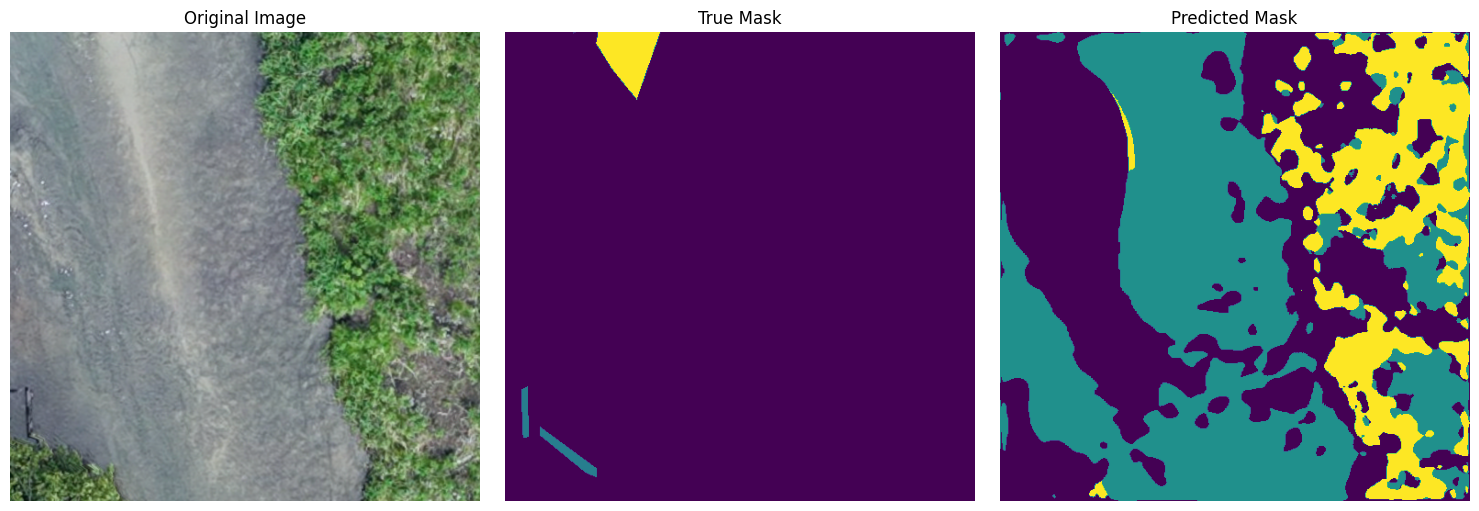

In [89]:
import matplotlib.pyplot as plt

# Wähle ein Beispiel aus dem Batch (z. B. erstes Bild)
example_idx = 0

# Originalbild
image = images[example_idx].permute(1, 2, 0).cpu().numpy()  # [C, H, W] -> [H, W, C]
image = (image - image.min()) / (image.max() - image.min())
# Zielmaske (mit argmax von [num_classes, H, W] zu [H, W])
true_mask = masks[example_idx].cpu().numpy().argmax(axis=0)  # [H, W]
# Vorhergesagte Maske (mit argmax von [num_classes, H, W] zu [H, W])
pred_mask = pred_classes[example_idx].cpu().numpy()  # [H, W]

# Visualisierung
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(true_mask, cmap="viridis")
axes[1].set_title("True Mask")
axes[1].axis("off")

axes[2].imshow(pred_mask, cmap="viridis")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [99]:
### Testing
# Setup variables for accumulatively adding up loss and accuracy
test_loss, test_acc = 0, 0
model.eval()
with torch.inference_mode():
  for names, images, masks in test_loader: # we do not need keep track of the batches in the test_dataloader again

    images, masks = images.to(device), masks.to(device)

    # 1. Forward pass
    test_pred = model(images)

    # 2. Calculate loss (accumulatively)
    test_loss += loss_fn(test_pred, masks) # accumulatively add up the loss per epoch

    # 3. Calculate accuracy (preds need to be same as y_true)
    test_acc += accuracy_fn(y_true=masks, y_pred=test_pred.softmax(dim=1)) # compare labels to labels

  # Calculations on test metrics need to happen inside torch.inference_mode()
  # Divide total test loss by length of test dataloader (per batch) =  test loss average per batch
  test_loss /= len(test_loader)

  # Divide total accuracy by length of test dataloader (per batch)
  test_acc /= len(test_loader)

## Print out what's happening
print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%\n")


Train loss: 0.0001 | Test loss: 0.0614, Test acc: 0.0000%



## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }